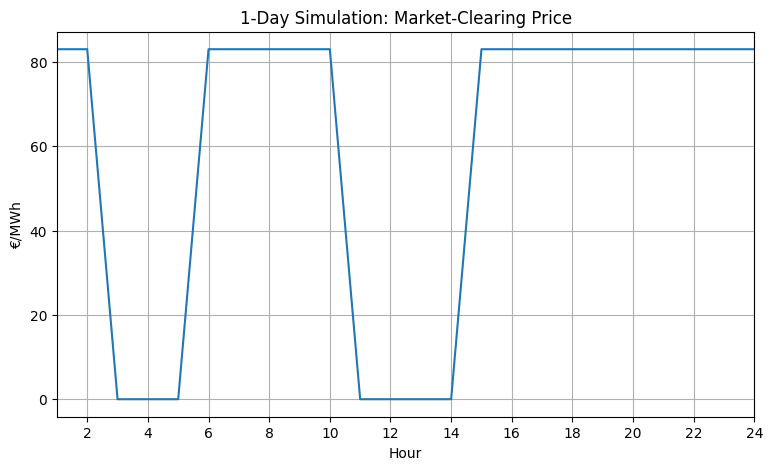

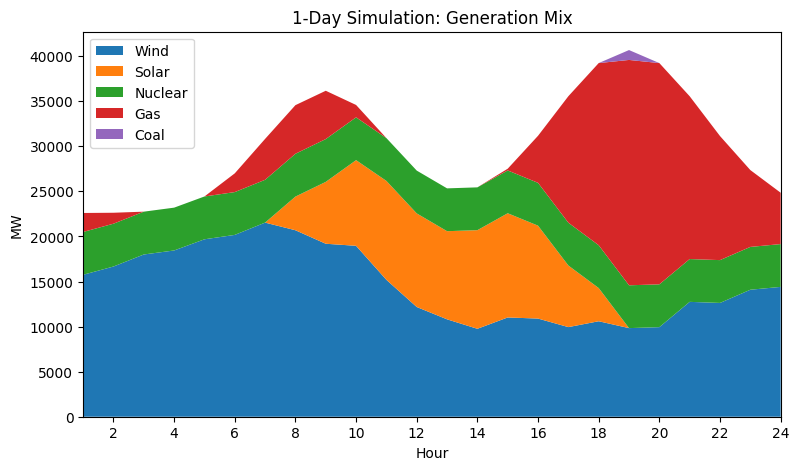

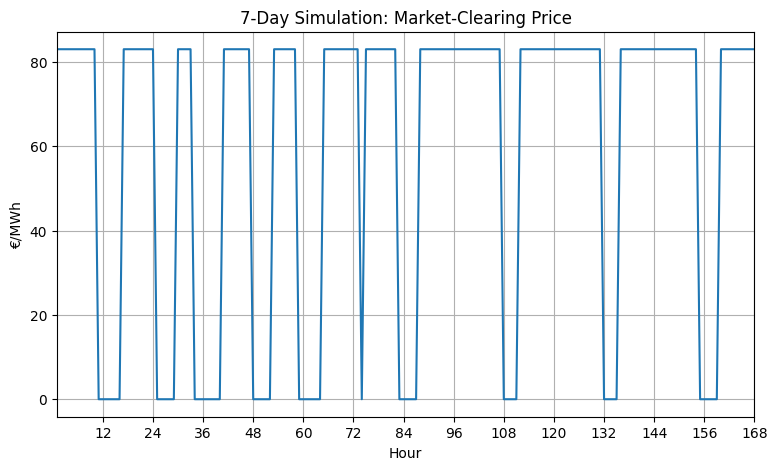

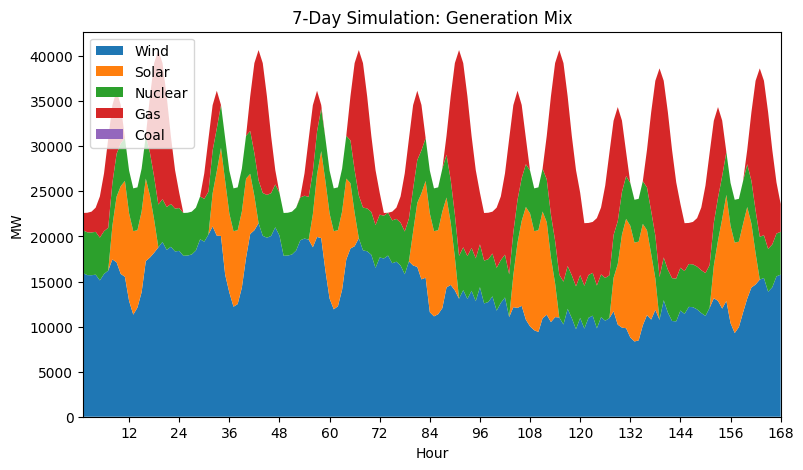

(     Hour  Price    Emissions        Demand
 0       1   83.0   677.386205  22602.315763
 1       2   83.0   758.761308  22627.426789
 2       3   83.0   805.158727  22748.390461
 3       4   83.0   940.310116  23193.493432
 4       5   83.0  1596.721763  24432.733943
 ..    ...    ...          ...           ...
 163   164   83.0  5997.942959  37269.004164
 164   165   83.0  5304.543783  33773.805133
 165   166   83.0  3663.034778  29580.445369
 166   167   83.0  1985.910848  25994.976140
 167   168   83.0  1083.837331  23606.328255
 
 [168 rows x 4 columns],
               Wind  Solar  Nuclear           Gas  Coal
 Hour                                                  
 1     15916.926606    0.0   4750.0   1935.389157     0
 2     15709.537338    0.0   4750.0   2167.889451     0
 3     15697.936956    0.0   4750.0   2300.453505     0
 4     15756.893101    0.0   4750.0   2686.600330     0
 5     15120.671763    0.0   4750.0   4562.062181     0
 ...            ...    ...      ...      

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

carbon_price = 80
base_demand = 30_000

hours_day = np.arange(24)
hours_week = np.arange(24 * 7)

NUCLEAR_BASELOAD_FRAC = 0.95  # nuclear cannot ramp quickly - assume constant nuclear contribution in this model

# UK-style generation mix
tech_base = pd.DataFrame({
    "Technology": ["Wind", "Solar", "Nuclear", "Gas", "Coal"],
    "Capacity_MW": [28_000, 14_000, 5_000, 25_000, 1_000],
    "VarCost_EUR_per_MWh": [0, 0, 10, 55, 90], # short run costs
    "CO2_tons_per_MWh": [0, 0, 0, 0.35, 0.9]
})

# Profiles
def generate_profiles(hours):
    n = len(hours)

    # Wind: smooth multi-day variability
    wind = (
        0.55
        + 0.18 * np.sin(np.linspace(0, 2 * np.pi, n))
        + np.random.normal(0, 0.025, n)
    )
    wind = np.clip(wind, 0, 1)

    # Solar: clock-based diurnal profile
    solar = np.zeros(n)
    for d in range(n // 24):
        h = np.arange(24)
        solar_day = np.clip(np.sin(np.pi * (h - 6) / 12), 0, 1)
        solar[d * 24:(d + 1) * 24] = solar_day

    solar *= np.random.uniform(0.95, 1.05, n)
    solar = np.clip(solar, 0, 1)

    # Demand: morning + evening peaks
    h = np.arange(24)
    morning = 0.6 * np.exp(-0.5 * (h - 8) ** 2 / 4)
    evening = 0.8 * np.exp(-0.5 * (h - 18) ** 2 / 6)
    shape = 1 + morning + evening
    shape /= shape.mean()

    demand = base_demand * np.tile(shape, n // 24)

    if n > 24:
        weekend = np.repeat([1] * 5 + [0.95] * 2, 24)
        demand *= weekend[:n]

    return wind, solar, demand


# Dispatch with curtailment & nuclear baseload
def dispatch_hour(t, wind, solar, demand_profile):
    gen = tech_base.copy()
    demand = demand_profile[t]

    # Available renewable capacity
    wind_avail = gen.loc[gen.Technology == "Wind", "Capacity_MW"].values[0] * wind[t]
    solar_avail = gen.loc[gen.Technology == "Solar", "Capacity_MW"].values[0] * solar[t]

    # Nuclear fixed near-baseload
    nuclear_output = (
        gen.loc[gen.Technology == "Nuclear", "Capacity_MW"].values[0]
        * NUCLEAR_BASELOAD_FRAC
    )

    # Curtailment logic
    low_carbon_supply = wind_avail + solar_avail + nuclear_output

    if low_carbon_supply >= demand:
        # Curtail renewables proportionally - not appropriate at this level to curtail to one maximum or prioritise 1 technology
        excess = low_carbon_supply - demand
        renew_total = wind_avail + solar_avail

        if renew_total > 0:
            wind_dispatch = wind_avail * (1 - excess / renew_total)
            solar_dispatch = solar_avail * (1 - excess / renew_total)
        else:
            wind_dispatch = solar_dispatch = 0

        nuclear_dispatch = nuclear_output
        gas_dispatch = coal_dispatch = 0
        price = 0  # zero-price hour

    else:
        # Use all renewables + nuclear, gas fills residual
        wind_dispatch = wind_avail
        solar_dispatch = solar_avail
        nuclear_dispatch = nuclear_output

        residual = demand - low_carbon_supply
        gas_dispatch = min(
            residual,
            gen.loc[gen.Technology == "Gas", "Capacity_MW"].values[0]
        )
        coal_dispatch = max(0, residual - gas_dispatch)

        price = (
            gen.loc[gen.Technology == "Gas", "VarCost_EUR_per_MWh"].values[0]
            + carbon_price * gen.loc[gen.Technology == "Gas", "CO2_tons_per_MWh"].values[0]
        )

    dispatch = {
        "Wind": wind_dispatch,
        "Solar": solar_dispatch,
        "Nuclear": nuclear_dispatch,
        "Gas": gas_dispatch,
        "Coal": coal_dispatch
    }

    emissions = (
        gas_dispatch * 0.35
        + coal_dispatch * 0.9
    )

    return dispatch, price, emissions, demand



# Simulation
def run_sim(hours, label):
    wind, solar, demand = generate_profiles(hours)

    results = []
    dispatch_log = []

    for t in range(len(hours)):
        dispatch, price, emis, dem = dispatch_hour(t, wind, solar, demand)

        results.append({
            "Hour": t + 1,
            "Price": price,
            "Emissions": emis,
            "Demand": dem
        })

        row = dispatch.copy()
        row["Hour"] = t + 1
        dispatch_log.append(row)

    results = pd.DataFrame(results)
    mix = pd.DataFrame(dispatch_log).set_index("Hour")

    # Axis logic ONCE
    start, end, step = (1, 24, 2) if len(hours) == 24 else (1, len(hours), 12)
    xticks = np.arange(start - 1, end + 1, step)

    # Price plot
    plt.figure(figsize=(9, 5))
    sns.lineplot(data=results, x="Hour", y="Price")
    plt.xticks(xticks)
    plt.xlim(start, end)
    plt.title(f"{label}: Market-Clearing Price")
    plt.ylabel("€/MWh")
    plt.xlabel("Hour")
    plt.grid(True)
    plt.show()

    # Generation mix plot
    plt.figure(figsize=(9, 5))
    plt.stackplot(mix.index, mix.T, labels=mix.columns)
    plt.xticks(xticks)
    plt.xlim(start, end)
    plt.title(f"{label}: Generation Mix")
    plt.ylabel("MW")
    plt.xlabel("Hour")
    plt.legend(loc="upper left")
    plt.show()

    return results, mix


run_sim(hours_day, "1-Day Simulation")
run_sim(hours_week, "7-Day Simulation")
